In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install Keras
# !pip install Tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
                                    

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

### 1. importing data

In [4]:
data = pd.read_csv("gas_turbines.csv")
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


### 2.1 getting data ready

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [6]:
data.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


### 2.2 detecting outliers

#### 1) distribution plot

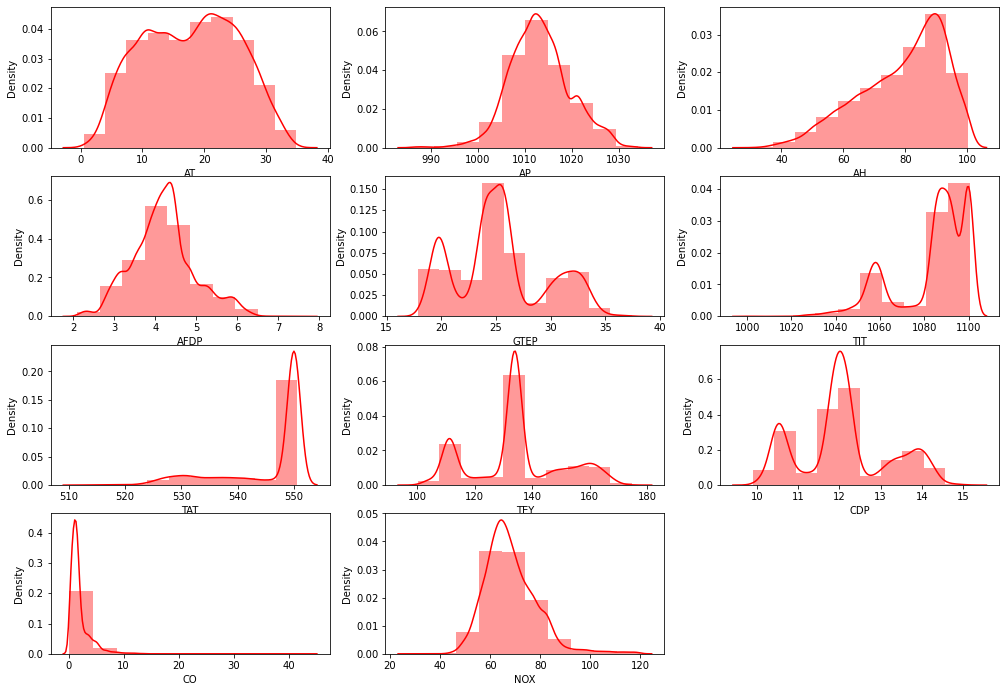

In [7]:
import seaborn as sns

plt.figure(figsize=(17,15)) 

plt.subplot(5,3,1)
sns.distplot(data['AT'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,2)
sns.distplot(data['AP'],bins=10,  kde = True, color =  'red' )
plt.subplot(5,3,3)
sns.distplot(data['AH'],bins=10,  kde = True, color =  'red' )    
plt.subplot(5,3,4)
sns.distplot(data['AFDP'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,5)
sns.distplot(data['GTEP'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,6)
sns.distplot(data['TIT'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,7)
sns.distplot(data['TAT'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,8)
sns.distplot(data['TEY'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,9)
sns.distplot(data['CDP'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,10)
sns.distplot(data['CO'],bins=10,  kde = True, color =  'red' )      
plt.subplot(5,3,11)
sns.distplot(data['NOX'],bins=10,  kde = True, color =  'red' )      

plt.show()

#for perfectly skewed N.D. kurtosis = 3

#### 2) isolation forest (detecting outliers)

In [8]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(random_state=10,contamination=.01)
model.fit(data)

y_pred_outliers = model.predict(data)
y_pred_outliers                            #-1 for outliers and 1 for inliers.


array([1, 1, 1, ..., 1, 1, 1])

In [9]:
data['scores']=model.decision_function(data)
data['anomaly']=model.predict(data.iloc[:,0:11])

data[data['anomaly']==-1]                                     #Print the outlier data points

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,scores,anomaly
44,4.3930,1021.50,86.622,3.8506,21.467,1037.9,528.08,116.72,11.141,31.9710,99.229,-0.047183,-1
112,15.3990,996.84,74.237,3.9852,22.193,1048.3,534.51,118.99,11.137,27.2500,83.232,-0.029768,-1
135,15.3270,992.42,77.042,3.9868,22.330,1049.8,535.33,119.04,11.208,26.9990,80.448,-0.028747,-1
155,7.0444,1006.40,96.843,4.0069,22.229,1048.1,532.44,121.93,11.328,31.5380,87.493,-0.017781,-1
197,5.5817,1016.70,85.499,3.8489,21.035,1035.4,527.44,114.07,11.064,35.0190,97.863,-0.039213,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,12.3620,1022.50,88.415,3.6979,21.238,1034.7,528.02,112.10,10.996,43.6220,80.193,-0.019900,-1
14855,10.6310,1007.10,95.055,3.3938,19.246,1026.1,531.18,105.36,10.357,7.7017,118.670,-0.020044,-1
14909,3.6984,1028.10,87.139,3.4336,19.777,1036.5,532.36,113.61,10.754,9.4722,116.460,-0.050317,-1
14911,3.5880,1028.80,88.069,3.4599,19.850,1044.5,537.32,115.65,10.785,8.2782,97.853,-0.010014,-1


#### 3)box plot

In [10]:
data = data.iloc[:,0:11]
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


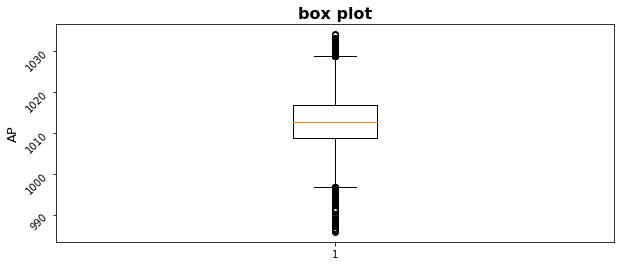

[array([1008.9 ,  996.91]), array([1016.9, 1028.9])]

In [11]:
plt.figure(figsize=(10,4))                                                   #setting the frame using figure size
#figsize = plt.figaspect(9/6)                                                #setting the frame using aspect ratio
plt.title("box plot", fontsize = 16, fontweight = "bold")                    #title
plt.ylabel("AP", fontsize = 13 )                                           #y-label
plt.yticks( rotation = 45, fontsize = 10)                                    #y-values rotation and font size


#box=plt.boxplot(x='AT', data=data)                                               
box=plt.boxplot(x='AP', data=data)
#box=plt.boxplot(x='AH', data=data)
#box=plt.boxplot(x='AFDP', data=data)
#box=plt.boxplot(x='GTEP', data=data)
#box=plt.boxplot(x='TIT', data=data)
#box=plt.boxplot(x='TAT', data=data)
#box=plt.boxplot(x='TEY', data=data)
#box=plt.boxplot(x='CDP', data=data)
#box=plt.boxplot(x='CO', data=data)
#box=plt.boxplot(x='NOX', data=data)

plt.show() 


[item.get_ydata() for item in box['whiskers']]


In [12]:
## Computing 90th and 10th percentile and replacing the outliers with 90th and 10th percentile as per requirement

p_90 = np.percentile(data['AP'], 90)
data.loc[data.AP > 1028.9, 'AP'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['AP'], 10)
data.loc[data.AP < 996.91, 'AP'] = np.nan
data.fillna(p_10,inplace=True)
p_10 = np.percentile(data['AH'], 10)
data.loc[data.AH < 39.393, 'AH'] = np.nan
data.fillna(p_10,inplace=True)
p_90 = np.percentile(data['AFDP'], 90)
data.loc[data.AFDP > 5.7911, 'AFDP'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['AFDP'], 10)
data.loc[data.AFDP < 2.491, 'AFDP'] = np.nan
data.fillna(p_10,inplace=True)
p_90 = np.percentile(data['GTEP'], 90)
data.loc[data.GTEP > 33.018, 'GTEP'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['TIT'], 10)
data.loc[data.TIT < 1055, 'TIT'] = np.nan
data.fillna(p_10,inplace=True)
p_10 = np.percentile(data['TAT'], 10)
data.loc[data.TAT < 530.34, 'TAT'] = np.nan
data.fillna(p_10,inplace=True)
p_90 = np.percentile(data['TEY'], 90)
data.loc[data.TEY > 160.25, 'TEY'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['TEY'], 10)
data.loc[data.TEY < 108.63, 'TEY'] = np.nan
data.fillna(p_10,inplace=True)
p_90 = np.percentile(data['CDP'], 90)
data.loc[data.CDP > 14.01, 'CDP'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['CDP'], 10)
data.loc[data.CDP < 10.188, 'CDP'] = np.nan
data.fillna(p_10,inplace=True)
p_90 = np.percentile(data['CO'], 90)
data.loc[data.CO > p_90, 'CO'] = np.nan
data.fillna(p_90,inplace=True)
p_90 = np.percentile(data['NOX'], 90)
data.loc[data.NOX > 92.862, 'NOX'] = np.nan
data.fillna(p_90,inplace=True)
p_10 = np.percentile(data['NOX'], 10)
data.loc[data.NOX < 43.274, 'NOX'] = np.nan
data.fillna(p_10,inplace=True)


### 2.3 scaling of data

In [13]:
data.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

In [14]:
# standardization of data 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)
data_s=pd.DataFrame(x_scaled)
data_s.columns=['AT','AP','AH','AFDP','GTEP','TIT','TAT','TEY','CDP','CO','NOX']

data_s.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,-1.439778,-0.878187,1.292814,-0.997157,-1.409454,-1.688911,0.604667,-1.289463,-1.398759,1.202456,1.680242
1,-1.449601,-0.795860,1.316253,-0.997451,-1.393323,-1.682232,0.604667,-1.288120,-1.405381,1.271038,1.686259
2,-1.434721,-0.729998,1.229625,-1.023005,-1.380666,-1.675552,0.586177,-1.288791,-1.402543,1.241538,1.651942
3,-1.413702,-0.664136,1.178926,-1.025795,-1.377439,-1.662193,0.603245,-1.288120,-1.397812,1.234058,1.674449
4,-1.368693,-0.581809,1.171652,-1.000682,-1.384140,-1.655514,0.601822,-1.288120,-1.392136,1.281208,1.634449


### 2.4 Splitting the data

In [15]:
x = data_s.drop('TEY',axis=1)
y = data_s[['TEY']]
x_array = x.values
y_array = y.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

### 3 Tuning of Hyperparameters

#### a) no of neurons, kernel initializer, activation function 

In [50]:
# 1) defining neural network model
def create_model(learning_rate,activation_function,init,neuron1,neuron2):                       #dropout_rate,
    
    model = Sequential()
    
    model.add(Dense(neuron1,input_dim = 10,kernel_initializer = init,activation = activation_function))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(1,activation = 'linear'))
    
    
    adam = Adam(lr = learning_rate)
    
    # 2) compiling neural network model    
    
    model.compile(loss = 'mean_absolute_error',optimizer = adam,metrics = ['mean_absolute_error'])
    return model

# 3) defining the sklearn type model
#we cann't directly use a keras model 
#sklearn create a wrapper around keras model. 
#So there is something called KerasClassifier in sklearn that take keras model & convert it into sklearn type of model.
model1 = KerasClassifier(build_fn = create_model,verbose = 0)




# Define the grid search parameters
#batch_size = [10,20,40]
#epochs = [10,50,100]
learning_rate = [0.001,0.01,0.1]
#dropout_rate = [0.0,0.1,0.2]
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters
param_grids = dict(learning_rate = learning_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2) 
                       #batch_size = batch_size,epochs = epochs,...,dropout_rate = dropout_rate,



# Build and fit the GridSearchCV
model_cv = GridSearchCV(estimator = model1,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = model_cv.fit(x_array,y_array)

#Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))  


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2
[CV 1/5; 1/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=  37.6s
[CV 2/5; 1/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2
[CV 2/5; 1/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   8.0s
[CV 3/5; 1/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2
[CV 3/5; 1/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   8.0s
[CV 4/5; 1/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuron2=2
[CV 4/5; 1/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=4, neuro

[CV 4/5; 7/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   7.2s
[CV 5/5; 7/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=2
[CV 5/5; 7/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   7.3s
[CV 1/5; 8/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4
[CV 1/5; 8/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   7.5s
[CV 2/5; 8/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4
[CV 2/5; 8/324] END activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.7s
[CV 3/5; 8/324] START activation_function=softmax, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4
[CV 3/5; 8/324] END 

[CV 3/5; 14/324] END activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.6s
[CV 4/5; 14/324] START activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=4
[CV 4/5; 14/324] END activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.5s
[CV 5/5; 14/324] START activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=4
[CV 5/5; 14/324] END activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.1s
[CV 1/5; 15/324] START activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8
[CV 1/5; 15/324] END activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.6s
[CV 2/5; 15/324] START activation_function=softmax, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8
[CV 2/5; 15/324] END activat

[CV 2/5; 21/324] END activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.4s
[CV 3/5; 21/324] START activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8
[CV 3/5; 21/324] END activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.0s
[CV 4/5; 21/324] START activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8
[CV 4/5; 21/324] END activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.2s
[CV 5/5; 21/324] START activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8
[CV 5/5; 21/324] END activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.1s
[CV 1/5; 22/324] START activation_function=softmax, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2
[CV 1/5; 22/324] END activation_func

[CV 1/5; 28/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.7s
[CV 2/5; 28/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2
[CV 2/5; 28/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   7.4s
[CV 3/5; 28/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2
[CV 3/5; 28/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.2s
[CV 4/5; 28/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2
[CV 4/5; 28/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.2s
[CV 5/5; 28/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=4, neuron2=2
[CV 5/5; 28/324] END activat

[CV 5/5; 34/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   6.3s
[CV 1/5; 35/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4
[CV 1/5; 35/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   7.0s
[CV 2/5; 35/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4
[CV 2/5; 35/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.4s
[CV 3/5; 35/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4
[CV 3/5; 35/324] END activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 4/5; 35/324] START activation_function=softmax, init=normal, learning_rate=0.001, neuron1=16, neuron2=4
[CV 4/5; 35/324] END

[CV 4/5; 41/324] END activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.3s
[CV 5/5; 41/324] START activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=4
[CV 5/5; 41/324] END activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.1s
[CV 1/5; 42/324] START activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=8
[CV 1/5; 42/324] END activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.7s
[CV 2/5; 42/324] START activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=8
[CV 2/5; 42/324] END activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.7s
[CV 3/5; 42/324] START activation_function=softmax, init=normal, learning_rate=0.01, neuron1=8, neuron2=8
[CV 3/5; 42/324] END activation_func

[CV 3/5; 48/324] END activation_function=softmax, init=normal, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.2s
[CV 4/5; 48/324] START activation_function=softmax, init=normal, learning_rate=0.1, neuron1=4, neuron2=8
[CV 4/5; 48/324] END activation_function=softmax, init=normal, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.7s
[CV 5/5; 48/324] START activation_function=softmax, init=normal, learning_rate=0.1, neuron1=4, neuron2=8
[CV 5/5; 48/324] END activation_function=softmax, init=normal, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.0s
[CV 1/5; 49/324] START activation_function=softmax, init=normal, learning_rate=0.1, neuron1=8, neuron2=2
[CV 1/5; 49/324] END activation_function=softmax, init=normal, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.5s
[CV 2/5; 49/324] START activation_function=softmax, init=normal, learning_rate=0.1, neuron1=8, neuron2=2
[CV 2/5; 49/324] END activation_function=sof

[CV 3/5; 55/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.3s
[CV 4/5; 55/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=2
[CV 4/5; 55/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.3s
[CV 5/5; 55/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=2
[CV 5/5; 55/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.1s
[CV 1/5; 56/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=4
[CV 1/5; 56/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.5s
[CV 2/5; 56/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=4, neuron2=4
[CV 2/5; 56/324] END activation_function=sof

[CV 3/5; 62/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 4/5; 62/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=4
[CV 4/5; 62/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.5s
[CV 5/5; 62/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=4
[CV 5/5; 62/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.1s
[CV 1/5; 63/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=8
[CV 1/5; 63/324] END activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   6.7s
[CV 2/5; 63/324] START activation_function=softmax, init=zero, learning_rate=0.001, neuron1=16, neuron2=8
[CV 2/5; 63/324] END activation_func

[CV 3/5; 69/324] END activation_function=softmax, init=zero, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.0s
[CV 4/5; 69/324] START activation_function=softmax, init=zero, learning_rate=0.01, neuron1=8, neuron2=8
[CV 4/5; 69/324] END activation_function=softmax, init=zero, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.3s
[CV 5/5; 69/324] START activation_function=softmax, init=zero, learning_rate=0.01, neuron1=8, neuron2=8
[CV 5/5; 69/324] END activation_function=softmax, init=zero, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.0s
[CV 1/5; 70/324] START activation_function=softmax, init=zero, learning_rate=0.01, neuron1=16, neuron2=2
[CV 1/5; 70/324] END activation_function=softmax, init=zero, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   7.2s
[CV 2/5; 70/324] START activation_function=softmax, init=zero, learning_rate=0.01, neuron1=16, neuron2=2
[CV 2/5; 70/324] END activation_function=softmax,

[CV 3/5; 76/324] END activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.1s
[CV 4/5; 76/324] START activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 4/5; 76/324] END activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.0s
[CV 5/5; 76/324] START activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 5/5; 76/324] END activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.1s
[CV 1/5; 77/324] START activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=4
[CV 1/5; 77/324] END activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   6.6s
[CV 2/5; 77/324] START activation_function=softmax, init=zero, learning_rate=0.1, neuron1=8, neuron2=4
[CV 2/5; 77/324] END activation_function=softmax, init=zero,

[CV 3/5; 83/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.1s
[CV 4/5; 83/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 4/5; 83/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.4s
[CV 5/5; 83/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 5/5; 83/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   5.8s
[CV 1/5; 84/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=8
[CV 1/5; 84/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   6.2s
[CV 2/5; 84/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=4, neuron2=8
[CV 2/5; 84/324] END activation_function=rel

[CV 3/5; 90/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   6.2s
[CV 4/5; 90/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 4/5; 90/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   7.1s
[CV 5/5; 90/324] START activation_function=relu, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 5/5; 90/324] END activation_function=relu, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.8s
[CV 1/5; 91/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2
[CV 1/5; 91/324] END activation_function=relu, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   6.0s
[CV 2/5; 91/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2
[CV 2/5; 91/324] END activation_function=r

[CV 3/5; 97/324] END activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.5s
[CV 4/5; 97/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2
[CV 4/5; 97/324] END activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.2s
[CV 5/5; 97/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2
[CV 5/5; 97/324] END activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   5.9s
[CV 1/5; 98/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4
[CV 1/5; 98/324] END activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   7.0s
[CV 2/5; 98/324] START activation_function=relu, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4
[CV 2/5; 98/324] END activation_function=rel

[CV 3/5; 104/324] END activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   6.5s
[CV 4/5; 104/324] START activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4
[CV 4/5; 104/324] END activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   6.9s
[CV 5/5; 104/324] START activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4
[CV 5/5; 104/324] END activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.8s
[CV 1/5; 105/324] START activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8
[CV 1/5; 105/324] END activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   6.0s
[CV 2/5; 105/324] START activation_function=relu, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8
[CV 2/5; 105/324] END activation_function=relu, init

[CV 3/5; 111/324] END activation_function=relu, init=normal, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   6.1s
[CV 4/5; 111/324] START activation_function=relu, init=normal, learning_rate=0.001, neuron1=4, neuron2=8
[CV 4/5; 111/324] END activation_function=relu, init=normal, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   5.8s
[CV 5/5; 111/324] START activation_function=relu, init=normal, learning_rate=0.001, neuron1=4, neuron2=8
[CV 5/5; 111/324] END activation_function=relu, init=normal, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   5.8s
[CV 1/5; 112/324] START activation_function=relu, init=normal, learning_rate=0.001, neuron1=8, neuron2=2
[CV 1/5; 112/324] END activation_function=relu, init=normal, learning_rate=0.001, neuron1=8, neuron2=2;, score=nan total time=   5.9s
[CV 2/5; 112/324] START activation_function=relu, init=normal, learning_rate=0.001, neuron1=8, neuron2=2
[CV 2/5; 112/324] END activation_function=re

[CV 3/5; 118/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   6.0s
[CV 4/5; 118/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=2
[CV 4/5; 118/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   6.8s
[CV 5/5; 118/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=2
[CV 5/5; 118/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   5.7s
[CV 1/5; 119/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=4
[CV 1/5; 119/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=4;, score=nan total time=   5.8s
[CV 2/5; 119/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=4, neuron2=4
[CV 2/5; 119/324] END activation_function=relu, init

[CV 3/5; 125/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 4/5; 125/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=4
[CV 4/5; 125/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 5/5; 125/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=4
[CV 5/5; 125/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 1/5; 126/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=8
[CV 1/5; 126/324] END activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=8;, score=nan total time=   6.1s
[CV 2/5; 126/324] START activation_function=relu, init=normal, learning_rate=0.01, neuron1=16, neuron2=8
[CV 2/5; 126/324] END activation_function=re

[CV 3/5; 132/324] END activation_function=relu, init=normal, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   6.2s
[CV 4/5; 132/324] START activation_function=relu, init=normal, learning_rate=0.1, neuron1=8, neuron2=8
[CV 4/5; 132/324] END activation_function=relu, init=normal, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   6.7s
[CV 5/5; 132/324] START activation_function=relu, init=normal, learning_rate=0.1, neuron1=8, neuron2=8
[CV 5/5; 132/324] END activation_function=relu, init=normal, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   6.1s
[CV 1/5; 133/324] START activation_function=relu, init=normal, learning_rate=0.1, neuron1=16, neuron2=2
[CV 1/5; 133/324] END activation_function=relu, init=normal, learning_rate=0.1, neuron1=16, neuron2=2;, score=nan total time=   6.3s
[CV 2/5; 133/324] START activation_function=relu, init=normal, learning_rate=0.1, neuron1=16, neuron2=2
[CV 2/5; 133/324] END activation_function=relu, init=norm

[CV 3/5; 139/324] END activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=2;, score=nan total time=   6.3s
[CV 4/5; 139/324] START activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=2
[CV 4/5; 139/324] END activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=2;, score=nan total time=   6.1s
[CV 5/5; 139/324] START activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=2
[CV 5/5; 139/324] END activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=2;, score=nan total time=   5.8s
[CV 1/5; 140/324] START activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=4
[CV 1/5; 140/324] END activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=4;, score=nan total time=   6.2s
[CV 2/5; 140/324] START activation_function=relu, init=zero, learning_rate=0.001, neuron1=8, neuron2=4
[CV 2/5; 140/324] END activation_function=relu, init=zero, l

[CV 3/5; 146/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=4;, score=nan total time=   6.4s
[CV 4/5; 146/324] START activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=4
[CV 4/5; 146/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=4;, score=nan total time=   6.6s
[CV 5/5; 146/324] START activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=4
[CV 5/5; 146/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=4;, score=nan total time=   5.8s
[CV 1/5; 147/324] START activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=8
[CV 1/5; 147/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=8;, score=nan total time=   6.1s
[CV 2/5; 147/324] START activation_function=relu, init=zero, learning_rate=0.01, neuron1=4, neuron2=8
[CV 2/5; 147/324] END activation_function=relu, init=zero, learning_

[CV 4/5; 153/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=16, neuron2=8;, score=nan total time=   6.1s
[CV 5/5; 153/324] START activation_function=relu, init=zero, learning_rate=0.01, neuron1=16, neuron2=8
[CV 5/5; 153/324] END activation_function=relu, init=zero, learning_rate=0.01, neuron1=16, neuron2=8;, score=nan total time=   6.0s
[CV 1/5; 154/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=4, neuron2=2
[CV 1/5; 154/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=4, neuron2=2;, score=nan total time=   6.0s
[CV 2/5; 154/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=4, neuron2=2
[CV 2/5; 154/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=4, neuron2=2;, score=nan total time=   5.9s
[CV 3/5; 154/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=4, neuron2=2
[CV 3/5; 154/324] END activation_function=relu, init=zero, learning_ra

[CV 5/5; 160/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=2;, score=nan total time=   5.9s
[CV 1/5; 161/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4
[CV 1/5; 161/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4;, score=nan total time=   6.6s
[CV 2/5; 161/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4
[CV 2/5; 161/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4;, score=nan total time=   6.3s
[CV 3/5; 161/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4
[CV 3/5; 161/324] END activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4;, score=nan total time=   6.5s
[CV 4/5; 161/324] START activation_function=relu, init=zero, learning_rate=0.1, neuron1=16, neuron2=4
[CV 4/5; 161/324] END activation_function=relu, init=zero, learning_

[CV 5/5; 167/324] END activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=4;, score=nan total time=   6.0s
[CV 1/5; 168/324] START activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8
[CV 1/5; 168/324] END activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8;, score=nan total time=   6.5s
[CV 2/5; 168/324] START activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8
[CV 2/5; 168/324] END activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8;, score=nan total time=   6.1s
[CV 3/5; 168/324] START activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8
[CV 3/5; 168/324] END activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8;, score=nan total time=   6.4s
[CV 4/5; 168/324] START activation_function=tanh, init=uniform, learning_rate=0.001, neuron1=8, neuron2=8
[CV 4/5; 168/324] END activation_fun

[CV 4/5; 174/324] END activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8;, score=nan total time=   7.6s
[CV 5/5; 174/324] START activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8
[CV 5/5; 174/324] END activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8;, score=nan total time=   6.4s
[CV 1/5; 175/324] START activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2
[CV 1/5; 175/324] END activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2;, score=nan total time=   7.0s
[CV 2/5; 175/324] START activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2
[CV 2/5; 175/324] END activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2;, score=nan total time=   6.0s
[CV 3/5; 175/324] START activation_function=tanh, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2
[CV 3/5; 175/324] END activation_function=ta

[CV 4/5; 181/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=2;, score=nan total time=   6.3s
[CV 5/5; 181/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=2
[CV 5/5; 181/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=2;, score=nan total time=   6.4s
[CV 1/5; 182/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4
[CV 1/5; 182/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4;, score=nan total time=   6.5s
[CV 2/5; 182/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4
[CV 2/5; 182/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4;, score=nan total time=   6.4s
[CV 3/5; 182/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4
[CV 3/5; 182/324] END activation_function=tanh, init

[CV 4/5; 188/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4;, score=nan total time=   7.2s
[CV 5/5; 188/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4
[CV 5/5; 188/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4;, score=nan total time=   5.9s
[CV 1/5; 189/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=8
[CV 1/5; 189/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=8;, score=nan total time=   6.6s
[CV 2/5; 189/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=8
[CV 2/5; 189/324] END activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=8;, score=nan total time=   6.3s
[CV 3/5; 189/324] START activation_function=tanh, init=uniform, learning_rate=0.1, neuron1=16, neuron2=8
[CV 3/5; 189/324] END activation_function=ta

[CV 4/5; 195/324] END activation_function=tanh, init=normal, learning_rate=0.001, neuron1=8, neuron2=8;, score=nan total time=   6.0s
[CV 5/5; 195/324] START activation_function=tanh, init=normal, learning_rate=0.001, neuron1=8, neuron2=8
[CV 5/5; 195/324] END activation_function=tanh, init=normal, learning_rate=0.001, neuron1=8, neuron2=8;, score=nan total time=   6.4s
[CV 1/5; 196/324] START activation_function=tanh, init=normal, learning_rate=0.001, neuron1=16, neuron2=2
[CV 1/5; 196/324] END activation_function=tanh, init=normal, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   6.9s
[CV 2/5; 196/324] START activation_function=tanh, init=normal, learning_rate=0.001, neuron1=16, neuron2=2
[CV 2/5; 196/324] END activation_function=tanh, init=normal, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   7.0s
[CV 3/5; 196/324] START activation_function=tanh, init=normal, learning_rate=0.001, neuron1=16, neuron2=2
[CV 3/5; 196/324] END activation_functi

[CV 4/5; 202/324] END activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=2;, score=nan total time=   6.0s
[CV 5/5; 202/324] START activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=2
[CV 5/5; 202/324] END activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=2;, score=nan total time=   6.2s
[CV 1/5; 203/324] START activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=4
[CV 1/5; 203/324] END activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.1s
[CV 2/5; 203/324] START activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=4
[CV 2/5; 203/324] END activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   7.2s
[CV 3/5; 203/324] START activation_function=tanh, init=normal, learning_rate=0.01, neuron1=8, neuron2=4
[CV 3/5; 203/324] END activation_function=tanh, init

[CV 4/5; 209/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=4;, score=nan total time=   5.9s
[CV 5/5; 209/324] START activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=4
[CV 5/5; 209/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=4;, score=nan total time=   9.1s
[CV 1/5; 210/324] START activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=8
[CV 1/5; 210/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.2s
[CV 2/5; 210/324] START activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=8
[CV 2/5; 210/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   6.6s
[CV 3/5; 210/324] START activation_function=tanh, init=normal, learning_rate=0.1, neuron1=4, neuron2=8
[CV 3/5; 210/324] END activation_function=tanh, init=normal,

[CV 4/5; 216/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=16, neuron2=8;, score=nan total time=   6.3s
[CV 5/5; 216/324] START activation_function=tanh, init=normal, learning_rate=0.1, neuron1=16, neuron2=8
[CV 5/5; 216/324] END activation_function=tanh, init=normal, learning_rate=0.1, neuron1=16, neuron2=8;, score=nan total time=   6.0s
[CV 1/5; 217/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=4, neuron2=2
[CV 1/5; 217/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.1s
[CV 2/5; 217/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=4, neuron2=2
[CV 2/5; 217/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=4, neuron2=2;, score=nan total time=   6.4s
[CV 3/5; 217/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=4, neuron2=2
[CV 3/5; 217/324] END activation_function=tanh, init=zero

[CV 4/5; 223/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   6.7s
[CV 5/5; 223/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=2
[CV 5/5; 223/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=2;, score=nan total time=   6.1s
[CV 1/5; 224/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=4
[CV 1/5; 224/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.3s
[CV 2/5; 224/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=4
[CV 2/5; 224/324] END activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.0s
[CV 3/5; 224/324] START activation_function=tanh, init=zero, learning_rate=0.001, neuron1=16, neuron2=4
[CV 3/5; 224/324] END activation_function=tanh, init

[CV 4/5; 230/324] END activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   6.5s
[CV 5/5; 230/324] START activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=4
[CV 5/5; 230/324] END activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=4;, score=nan total time=   9.1s
[CV 1/5; 231/324] START activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=8
[CV 1/5; 231/324] END activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   8.0s
[CV 2/5; 231/324] START activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=8
[CV 2/5; 231/324] END activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   7.9s
[CV 3/5; 231/324] START activation_function=tanh, init=zero, learning_rate=0.01, neuron1=8, neuron2=8
[CV 3/5; 231/324] END activation_function=tanh, init=zero, learning_

[CV 5/5; 237/324] END activation_function=tanh, init=zero, learning_rate=0.1, neuron1=4, neuron2=8;, score=nan total time=   5.9s
[CV 1/5; 238/324] START activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 1/5; 238/324] END activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.3s
[CV 2/5; 238/324] START activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 2/5; 238/324] END activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.3s
[CV 3/5; 238/324] START activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 3/5; 238/324] END activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.7s
[CV 4/5; 238/324] START activation_function=tanh, init=zero, learning_rate=0.1, neuron1=8, neuron2=2
[CV 4/5; 238/324] END activation_function=tanh, init=zero, learning_rate=0.1

[CV 1/5; 245/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.2s
[CV 2/5; 245/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 2/5; 245/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   5.8s
[CV 3/5; 245/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 3/5; 245/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.1s
[CV 4/5; 245/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 4/5; 245/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.0s
[CV 5/5; 245/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=4, neuron2=4
[CV 5/5; 245/324] EN

[CV 5/5; 251/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=4;, score=nan total time=   6.2s
[CV 1/5; 252/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 1/5; 252/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   6.7s
[CV 2/5; 252/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 2/5; 252/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   6.2s
[CV 3/5; 252/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 3/5; 252/324] END activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   6.7s
[CV 4/5; 252/324] START activation_function=linear, init=uniform, learning_rate=0.001, neuron1=16, neuron2=8
[CV 4/5; 252

[CV 4/5; 258/324] END activation_function=linear, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   6.3s
[CV 5/5; 258/324] START activation_function=linear, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8
[CV 5/5; 258/324] END activation_function=linear, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   5.8s
[CV 1/5; 259/324] START activation_function=linear, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2
[CV 1/5; 259/324] END activation_function=linear, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.6s
[CV 2/5; 259/324] START activation_function=linear, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2
[CV 2/5; 259/324] END activation_function=linear, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.7s
[CV 3/5; 259/324] START activation_function=linear, init=uniform, learning_rate=0.01, neuron1=16, neuron2=2
[CV 3/5; 259/324] END a

[CV 3/5; 265/324] END activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.8s
[CV 4/5; 265/324] START activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2
[CV 4/5; 265/324] END activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.1s
[CV 5/5; 265/324] START activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2
[CV 5/5; 265/324] END activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   6.1s
[CV 1/5; 266/324] START activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4
[CV 1/5; 266/324] END activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.9s
[CV 2/5; 266/324] START activation_function=linear, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4
[CV 2/5; 266/324] END activation_fun

[CV 2/5; 272/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.0s
[CV 3/5; 272/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4
[CV 3/5; 272/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.2s
[CV 4/5; 272/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4
[CV 4/5; 272/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   5.9s
[CV 5/5; 272/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4
[CV 5/5; 272/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   6.1s
[CV 1/5; 273/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=4, neuron2=8
[CV 1/5; 273/324] END activa

[CV 1/5; 279/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.7s
[CV 2/5; 279/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8
[CV 2/5; 279/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.8s
[CV 3/5; 279/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8
[CV 3/5; 279/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.8s
[CV 4/5; 279/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8
[CV 4/5; 279/324] END activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.7s
[CV 5/5; 279/324] START activation_function=linear, init=normal, learning_rate=0.001, neuron1=16, neuron2=8
[CV 5/5; 279/324] EN

[CV 5/5; 285/324] END activation_function=linear, init=normal, learning_rate=0.01, neuron1=8, neuron2=8;, score=nan total time=   5.3s
[CV 1/5; 286/324] START activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2
[CV 1/5; 286/324] END activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.1s
[CV 2/5; 286/324] START activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2
[CV 2/5; 286/324] END activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   5.8s
[CV 3/5; 286/324] START activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2
[CV 3/5; 286/324] END activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   6.5s
[CV 4/5; 286/324] START activation_function=linear, init=normal, learning_rate=0.01, neuron1=16, neuron2=2
[CV 4/5; 286/324] END activat

[CV 5/5; 292/324] END activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=2;, score=nan total time=   5.2s
[CV 1/5; 293/324] START activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4
[CV 1/5; 293/324] END activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.6s
[CV 2/5; 293/324] START activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4
[CV 2/5; 293/324] END activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.6s
[CV 3/5; 293/324] START activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4
[CV 3/5; 293/324] END activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.5s
[CV 4/5; 293/324] START activation_function=linear, init=normal, learning_rate=0.1, neuron1=8, neuron2=4
[CV 4/5; 293/324] END activation_function=li

[CV 5/5; 299/324] END activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=4;, score=nan total time=   5.5s
[CV 1/5; 300/324] START activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8
[CV 1/5; 300/324] END activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   5.6s
[CV 2/5; 300/324] START activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8
[CV 2/5; 300/324] END activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   5.6s
[CV 3/5; 300/324] START activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8
[CV 3/5; 300/324] END activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8;, score=nan total time=   5.9s
[CV 4/5; 300/324] START activation_function=linear, init=zero, learning_rate=0.001, neuron1=4, neuron2=8
[CV 4/5; 300/324] END activation_function=li

[CV 5/5; 306/324] END activation_function=linear, init=zero, learning_rate=0.001, neuron1=16, neuron2=8;, score=nan total time=   5.6s
[CV 1/5; 307/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2
[CV 1/5; 307/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   5.6s
[CV 2/5; 307/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2
[CV 2/5; 307/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   5.5s
[CV 3/5; 307/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2
[CV 3/5; 307/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2;, score=nan total time=   6.3s
[CV 4/5; 307/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=4, neuron2=2
[CV 4/5; 307/324] END activation_function=linear, 

[CV 5/5; 313/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=2;, score=nan total time=   5.6s
[CV 1/5; 314/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4
[CV 1/5; 314/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   5.9s
[CV 2/5; 314/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4
[CV 2/5; 314/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   5.9s
[CV 3/5; 314/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4
[CV 3/5; 314/324] END activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4;, score=nan total time=   5.7s
[CV 4/5; 314/324] START activation_function=linear, init=zero, learning_rate=0.01, neuron1=16, neuron2=4
[CV 4/5; 314/324] END activation_function=li

[CV 5/5; 320/324] END activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=4;, score=nan total time=   5.5s
[CV 1/5; 321/324] START activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8
[CV 1/5; 321/324] END activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   5.6s
[CV 2/5; 321/324] START activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8
[CV 2/5; 321/324] END activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   5.4s
[CV 3/5; 321/324] START activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8
[CV 3/5; 321/324] END activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8;, score=nan total time=   5.7s
[CV 4/5; 321/324] START activation_function=linear, init=zero, learning_rate=0.1, neuron1=8, neuron2=8
[CV 4/5; 321/324] END activation_function=linear, init=zero,

nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 2}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 4}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 8}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 2}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 4}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 8}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 16, 'neuron2': 2}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 16, 'neuron2': 4}
nan,nan with: {'activation_function': 'relu', 'init': 'uniform

nan,nan with: {'activation_function': 'relu', 'init': 'zero', 'learning_rate': 0.1, 'neuron1': 16, 'neuron2': 2}
nan,nan with: {'activation_function': 'relu', 'init': 'zero', 'learning_rate': 0.1, 'neuron1': 16, 'neuron2': 4}
nan,nan with: {'activation_function': 'relu', 'init': 'zero', 'learning_rate': 0.1, 'neuron1': 16, 'neuron2': 8}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 2}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 4}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 8}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 2}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 4}
nan,nan with: {'activation_function': 'tanh', 'init': 'uniform', 'learning_r

nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 4, 'neuron2': 8}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 2}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 4}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 8}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 16, 'neuron2': 2}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 16, 'neuron2': 4}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.001, 'neuron1': 16, 'neuron2': 8}
nan,nan with: {'activation_function': 'linear', 'init': 'normal', 'learning_rate': 0.01, 'neuron1': 4, 'neuron2': 2}
nan,nan with: {'activation_function': 'linear', 'init'

In [60]:
#best : 
       # 1. activation function = 'softmax'
       # 2. kernel initializer = 'uniform'
       # 3. learning rate = 0.001
       # 4. neuron1 = 4
       # 5. neuron2 = 2

#### b) batch size, epochs

In [59]:
# 1) defining neural network model
def create_model():                       
    
    model = Sequential()
    
    model.add(Dense(4,input_dim = 10,kernel_initializer = 'uniform',activation = 'softmax'))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(2,input_dim = 4,kernel_initializer = 'uniform',activation = 'softmax'))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(1,activation = 'linear'))
    
    
    adam = Adam(lr = 0.001)
    
    # 2) compiling neural network model    
    
    model.compile(loss = 'mean_absolute_error',optimizer = adam,metrics = ['mean_absolute_error'])
    return model

# 3) defining the sklearn type model
#we cann't directly use a keras model 
#sklearn create a wrapper around keras model. 
#So there is something called KerasClassifier in sklearn that take keras model & convert it into sklearn type of model.
model1 = KerasClassifier(build_fn = create_model,verbose = 0)



# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,50,100]
#learning_rate = [0.001,0.01,0.1]
#dropout_rate = [0.0,0.1,0.2]
#activation_function = ['softmax','relu','tanh','linear']
#init = ['uniform','normal','zero']
#neuron1 = [4,8,16]
#neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters
param_grids = dict(batch_size = batch_size,epochs = epochs)                #dropout_rate = dropout_rate,
                   


# Build and fit the GridSearchCV
model_cv = GridSearchCV(estimator = model1,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = model_cv.fit(x_array,y_array)

#Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))  


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=10, epochs=10....................................
[CV 1/5; 1/9] END .......batch_size=10, epochs=10;, score=nan total time= 1.7min
[CV 2/5; 1/9] START batch_size=10, epochs=10....................................
[CV 2/5; 1/9] END .......batch_size=10, epochs=10;, score=nan total time= 1.3min
[CV 3/5; 1/9] START batch_size=10, epochs=10....................................
[CV 3/5; 1/9] END .......batch_size=10, epochs=10;, score=nan total time= 1.3min
[CV 4/5; 1/9] START batch_size=10, epochs=10....................................
[CV 4/5; 1/9] END .......batch_size=10, epochs=10;, score=nan total time= 1.3min
[CV 5/5; 1/9] START batch_size=10, epochs=10....................................
[CV 5/5; 1/9] END .......batch_size=10, epochs=10;, score=nan total time= 1.3min
[CV 1/5; 2/9] START batch_size=10, epochs=50....................................
[CV 1/5; 2/9] END .......batch_size=10, epochs=50

In [ ]:
#best :
       # 1. batch size = 10
       # 2. epochs = 10

#### c) dropout rate

In [67]:
# 1) defining neural network model
def create_model(dropout_rate):     #in the function argument please do write dropout rate otherwise it will give not a legal parameter error               
    model = Sequential()
    model.add(Dense(4,input_dim = 10,kernel_initializer = 'uniform',activation = 'softmax'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2,input_dim = 4,kernel_initializer = 'uniform',activation = 'softmax'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'linear'))
    adam = Adam(lr = 0.001)
    
    # 2) compiling neural network model    
    
    model.compile(loss = 'mean_absolute_error',optimizer = adam,metrics = ['mean_absolute_error'])
    return model

# 3) defining the sklearn type model
#we cann't directly use a keras model 
#sklearn create a wrapper around keras model. 
#So there is something called KerasClassifier in sklearn that take keras model & convert it into sklearn type of model.
model1 = KerasClassifier(build_fn = create_model,verbose = 0, batch_size = 10,epochs = 10)



# Define the grid search parameters
#batch_size = [10,20,40]
#epochs = [10,50,100]
#learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]
#activation_function = ['softmax','relu','tanh','linear']
#init = ['uniform','normal','zero']
#neuron1 = [4,8,16]
#neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters
param_grids = dict(dropout_rate = dropout_rate)                
                   


# Build and fit the GridSearchCV
model_cv = GridSearchCV(estimator = model1,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = model_cv.fit(x_array,y_array)

#Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))  


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START dropout_rate=0.0............................................
[CV 1/5; 1/3] END ...............dropout_rate=0.0;, score=nan total time= 1.3min
[CV 2/5; 1/3] START dropout_rate=0.0............................................
[CV 2/5; 1/3] END ...............dropout_rate=0.0;, score=nan total time= 1.3min
[CV 3/5; 1/3] START dropout_rate=0.0............................................
[CV 3/5; 1/3] END ...............dropout_rate=0.0;, score=nan total time= 1.3min
[CV 4/5; 1/3] START dropout_rate=0.0............................................
[CV 4/5; 1/3] END ...............dropout_rate=0.0;, score=nan total time= 1.3min
[CV 5/5; 1/3] START dropout_rate=0.0............................................
[CV 5/5; 1/3] END ...............dropout_rate=0.0;, score=nan total time= 1.3min
[CV 1/5; 2/3] START dropout_rate=0.1............................................
[CV 1/5; 2/3] END ...............dropout_rate=0.1

In [66]:
# best : 
        # a) dropout rate = 0.0

### 4 building neural network model

In [16]:
# 1) defining neural network model
model = Sequential()
model.add(Dense(4,input_dim = 10,kernel_initializer = 'uniform',activation = 'softmax'))
model.add(Dropout(0.0))
model.add(Dense(2,input_dim = 4,kernel_initializer = 'uniform',activation = 'softmax'))
model.add(Dropout(0.0))
model.add(Dense(1,activation = 'linear'))
adam = Adam(lr = 0.001)
    
# 2) compiling neural network model    
model.compile(loss = 'mean_absolute_error',optimizer = adam,metrics = ['mean_absolute_error'])
    

# 3) Fit the model
history = model.fit(x, y, validation_split=0.33, epochs=10, batch_size=10)


Epoch 1/10
1008/1008 [==============================] - 10s 7ms/step - loss: 0.6321 - mean_absolute_error: 0.6321 - val_loss: 0.4202 - val_mean_absolute_error: 0.4202
Epoch 2/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.2672 - mean_absolute_error: 0.2672 - val_loss: 0.1055 - val_mean_absolute_error: 0.1055
Epoch 3/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0715 - val_mean_absolute_error: 0.0715
Epoch 4/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0622 - val_mean_absolute_error: 0.0622
Epoch 5/10
1008/1008 [==============================] - 7s 7ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 6/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.0437 - mean_absolute_error: 0.0437 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epo

In [17]:
# evaluate the model
scores = model.evaluate(x, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

470/470 [==============================] - 2s 4ms/step - loss: 0.0429 - mean_absolute_error: 0.0429
mean_absolute_error: 4.29%


In [18]:
# Visualize training history

# list all data in history
model.history.history.keys()

dict_keys([])

In [19]:
model.metrics_names

['loss', 'mean_absolute_error']

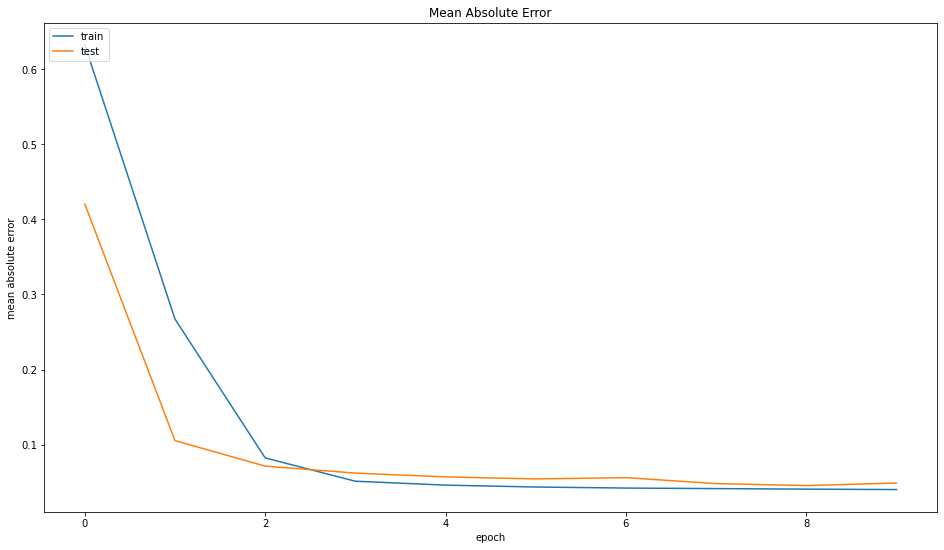

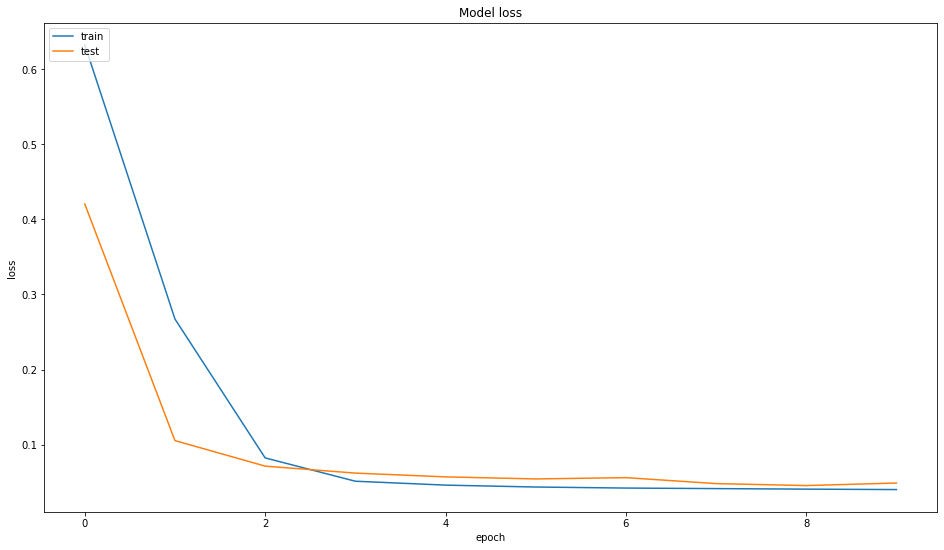

In [20]:
plt.figure(figsize=(16,9))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title("Mean Absolute Error")
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.legend(['train', 'test'],loc = 'upper left')
plt.show()
#summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'],loc='upper left')
plt.show()
